EECE 798S Hackathon
Team: Zaynab Al Haj, Rasha Malaeb, Omar Ramadan

#Model Loading

In [1]:
from google.colab import userdata
hf_token = userdata.get("hack-ai")
if hf_token: print(f"Hugging Face token loaded: {hf_token[:8]}...")
else: print("HF token not found. Please save it in the environment variables.")



Hugging Face token loaded: hf_XfuFW...


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BlipProcessor, BlipForConditionalGeneration
import torch

model_name = "tiiuae/Falcon3-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, token=hf_token, torch_dtype=torch.bfloat16, trust_remote_code=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

# Dataset

https://huggingface.co/datasets/theatticusproject/cuad/tree/main/CUAD_v1

# Iterative Steps

## Trial 1 - Initial Attempt on non-legal documents

Hugging Face token loaded: hf_XfuFW...


Device set to use cuda:0


📄 Please upload your .txt file (the legal document).


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saving ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT.txt to ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT (1).txt
Received: ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT (1).txt
Text length: 26,346 chars | Chunks: 17
✨ Creating knowledge graph from uploaded document (sanitized, no internal LLM calls)...
✅ Total number of edges: 9
{'node_1': {'label': 'Miscellaneous', 'name': 'TELCOSTAR PTE, LTD.'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Ability Computer & Software Industries Ltd.'}, 'relationship': 'PartyTo', 'description': 'Both are parties to the Services Agreement.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'TELCOSTAR PTE, LTD.'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Ability Computer & Software Industries Ltd.'}, 'relationship': 'PartyTo', 'description': 'Both are parties to the Services Agreement.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'Company X'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Company Z'}, 'relationship': 'SupplierT

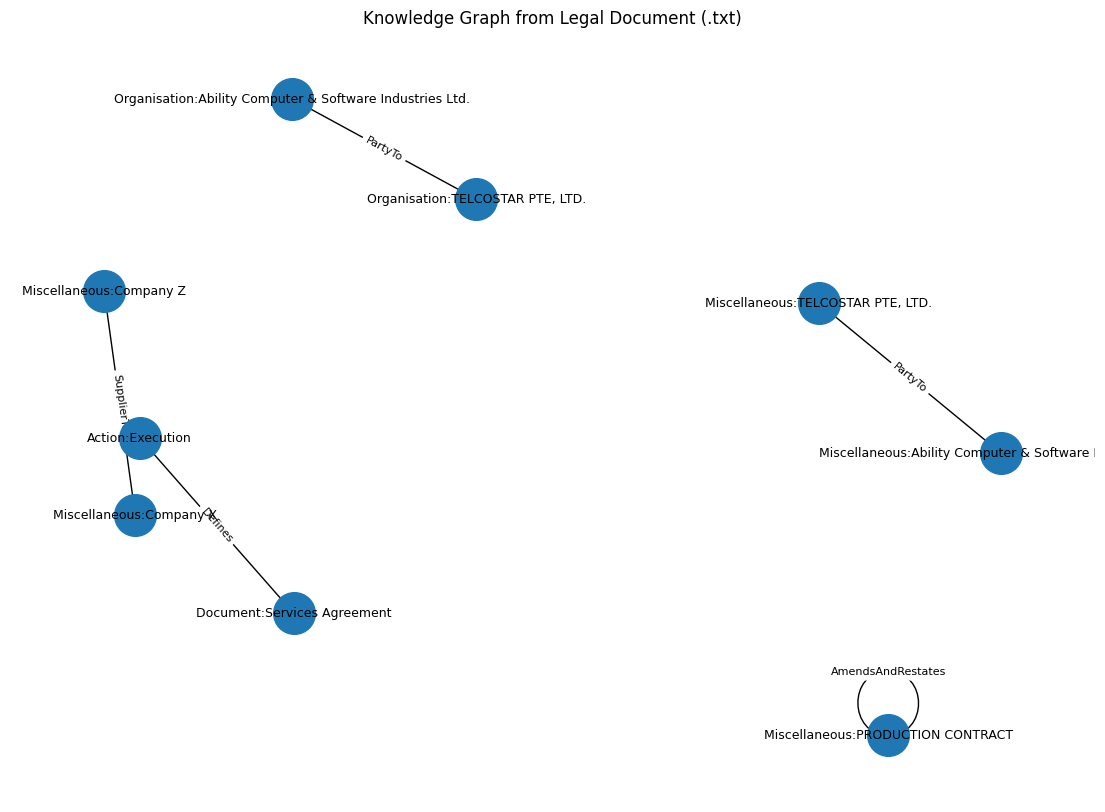

In [ ]:
# -*- coding: utf-8 -*-

!pip -q install knowledge-graph-maker transformers accelerate

from google.colab import userdata, files
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from knowledge_graph_maker import Ontology, Document
import torch, json, re, datetime
import networkx as nx
import matplotlib.pyplot as plt

hf_token = userdata.get("hack-ai")
if hf_token:
    print(f"Hugging Face token loaded: {hf_token[:8]}...")
else:
    print("HF token not found. In a separate cell, run:")
    print("from google.colab import userdata; userdata.set('hack-ai','<your_hf_token>')")

model_name = "tiiuae/Falcon3-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    torch_dtype=torch.bfloat16
)


generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.0,
    top_p=1.0
)

class HuggingFaceClient:
    def __init__(self, generator):
        self.generator = generator

    def generate(self, user_message, system_message=""):
        prompt = f"""{system_message}

Return ONLY a JSON array. Use DOUBLE-QUOTED keys. Example:

[
  {{
    "node_1": {{"label":"Organisation","name":"TELCOSTAR PTE, LTD."}},
    "node_2": {{"label":"Organisation","name":"Ability Computer & Software Industries Ltd."}},
    "relationship": "PartyTo",
    "description": "Both are parties to the Services Agreement."
  }}
]

User: {user_message}
Assistant:"""
        out = self.generator(prompt, do_sample=False)
        text = out[0]["generated_text"]
        return text.split("Assistant:")[-1].strip()

llm = HuggingFaceClient(generator)


ontology = Ontology(
    labels=[
        {"Person": "Person name without any adjectives. May be referenced by name or pronoun."},
        {"Object": "Do not add the definite article 'the' in the object name."},
        {"Event": "Event involving multiple people. Do not include verbs like gives, leaves, works."},
        "Place",
        "Document",
        "Organisation",
        "Action",
        {"Miscellaneous": "Any important concept that cannot be categorized with any other label."},
    ],
    relationships=["Relation between any pair of Entities"]
)

ALLOWED_LABELS = {"Person","Object","Event","Place","Document","Organisation","Action","Miscellaneous"}

def _quote_unquoted_keys(s: str) -> str:
    return re.sub(r'(?P<sep>[{,\s])(?P<key>[A-Za-z_]\w*)\s*:', r'\g<sep>"\g<key>":', s)

def _strip_trailing_commas(s: str) -> str:
    return re.sub(r',\s*([}\]])', r'\1', s)

def _force_array(s: str) -> str:
    t = s.strip()
    if t.startswith('{') and t.endswith('}'):
        return f'[{t}]'
    return t

def extract_json_edges(output_str):
    cleaned = output_str.replace('<|assistant|>', '').strip()
    cleaned = _quote_unquoted_keys(cleaned)
    cleaned = _strip_trailing_commas(cleaned)
    cleaned = _force_array(cleaned)

    try:
        parsed = json.loads(cleaned)
        if isinstance(parsed, dict):
            parsed = [parsed]
        if isinstance(parsed, list):
            return parsed
    except json.JSONDecodeError:
        pass

    objs = re.findall(r'\{.*?\}(?=\s*(?:\{|\]|$))', cleaned, flags=re.DOTALL)
    edges = []
    for obj in objs:
        try:
            edges.append(json.loads(_strip_trailing_commas(_quote_unquoted_keys(obj))))
        except json.JSONDecodeError:
            continue
    return edges

def _normalize_label(label: str) -> str:
    if not label:
        return "Miscellaneous"
    role_to_org = {"Provider","Recipient","Subcontractor","Party","Parties","Provider Representatives"}
    norm = label.strip()
    if norm in role_to_org:
        return "Organisation"

    titleish = norm.strip().title()
    return titleish if titleish in ALLOWED_LABELS else ("Organisation" if norm in role_to_org else ("Miscellaneous" if norm not in ALLOWED_LABELS else norm))

def _is_generic_name(name: str) -> bool:
    return name.strip().lower() in {"provider","recipient","subcontractor","party","parties","provider representatives","services agreement"}

def sanitize_edges(edges_raw):
    sanitized, seen = [], set()
    for e in edges_raw:
        if not isinstance(e, dict):
            continue
        n1, n2 = e.get("node_1"), e.get("node_2")
        rel = e.get("relationship") or e.get("relation") or e.get("edge")
        if not rel and isinstance(n1, dict) and "relationship" in n1:
            rel = n1.pop("relationship", None)
        if not (isinstance(n1, dict) and isinstance(n2, dict) and isinstance(rel, str) and rel.strip()):
            continue

        l1 = _normalize_label(n1.get("label"))
        l2 = _normalize_label(n2.get("label"))
        name1 = (n1.get("name") or "").strip()
        name2 = (n2.get("name") or "").strip()
        if not name1 or not name2:
            continue
        if _is_generic_name(name1) and _is_generic_name(name2):
            continue

        edge = {
            "node_1": {"label": l1, "name": name1},
            "node_2": {"label": l2, "name": name2},
            "relationship": rel.strip(),
        }
        desc = e.get("description")
        if isinstance(desc, str) and desc.strip():
            edge["description"] = desc.strip()

        key = (edge["node_1"]["label"], edge["node_1"]["name"],
               edge["node_2"]["label"], edge["node_2"]["name"], edge["relationship"])
        if key in seen:
            continue
        seen.add(key)
        sanitized.append(edge)
    return sanitized

def generate_edges(text, max_retries=2):
    SYS_PROMPT = (
        "Extract a knowledge graph from the text. "
        "Return ONLY a JSON array of edges. "
        "Each edge MUST have keys: "
        "\"node_1\" (obj with \"label\",\"name\"), "
        "\"node_2\" (obj with \"label\",\"name\"), "
        "\"relationship\" (string), and optional \"description\"."
    )
    for _ in range(max_retries + 1):
        raw = llm.generate(user_message=text, system_message=SYS_PROMPT)
        edges_raw = extract_json_edges(raw)
        edges = sanitize_edges(edges_raw)
        if edges:
            return edges
    return []

print("Please upload your .txt file (the legal document).")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print(f"Received: {filename}")

with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    full_text = f.read()


def chunk_text(s, chunk_size=1800, overlap=200):
    chunks = []
    start, n = 0, len(s)
    while start < n:
        end = min(start + chunk_size, n)
        chunks.append(s[start:end])
        if end == n:
            break
        start = max(0, end - overlap)
    return chunks

chunks = chunk_text(full_text, chunk_size=1800, overlap=200)
print(f"Text length: {len(full_text):,} chars | Chunks: {len(chunks)}")

current_time = str(datetime.datetime.now())
docs = [Document(text=ch, metadata={"generated_at": current_time}) for ch in chunks]


print("Creating knowledge graph from uploaded document (sanitized, no internal LLM calls)...")
all_edges = []
for d in docs:
    d.metadata["edges"] = generate_edges(d.text)
    all_edges.extend(d.metadata["edges"])

if "Services Agreement" in full_text or "This Services Agreement" in full_text:
    seed = {
        "node_1": {"label":"Document","name":"Services Agreement"},
        "node_2": {"label":"Action","name":"Execution"},
        "relationship": "Defines"
    }
    key_seed = (seed['node_1']['label'], seed['node_1']['name'],
                seed['node_2']['label'], seed['node_2']['name'], seed['relationship'])
    exist = {(e['node_1']['label'], e['node_1']['name'],
              e['node_2']['label'], e['node_2']['name'], e['relationship']) for e in all_edges}
    if key_seed not in exist:
        all_edges.append(seed)

print("Total number of edges:", len(all_edges))
for e in all_edges[:10]:
    print(e, "\n")

G = nx.DiGraph()
for e in all_edges:
    n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
    n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
    rel = e["relationship"]
    G.add_node(n1)
    G.add_node(n2)
    G.add_edge(n1, n2, relationship=rel)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.8, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=900)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)},
    font_size=8
)
plt.axis('off')
plt.title("Knowledge Graph from Legal Document (.txt)")
plt.show()

## Trial 2 - Initial Attempt on legal documents

Hugging Face token loaded: hf_XfuFW...


Device set to use cuda:0


📄 Please upload your .txt file (the legal document).


Saving ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT.txt to ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT (2).txt
Received: ABILITYINC_06_15_2020-EX-4.25-SERVICES%20AGREEMENT (2).txt
Text length: 26,346 chars | Chunks: 17
✨ Creating knowledge graph from uploaded document (sanitized, no internal LLM calls)...
✅ Total number of edges: 9
{'node_1': {'label': 'Miscellaneous', 'name': 'TELCOSTAR PTE, LTD.'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Ability Computer & Software Industries Ltd.'}, 'relationship': 'PartyTo', 'description': 'Both are parties to the Services Agreement.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'TELCOSTAR PTE, LTD.'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Ability Computer & Software Industries Ltd.'}, 'relationship': 'PartyTo', 'description': 'Both are parties to the Services Agreement.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'Company X'}, 'node_2': {'label': 'Miscellaneous', 'name': 'Company Z'}, 'relationship': 'SupplierT

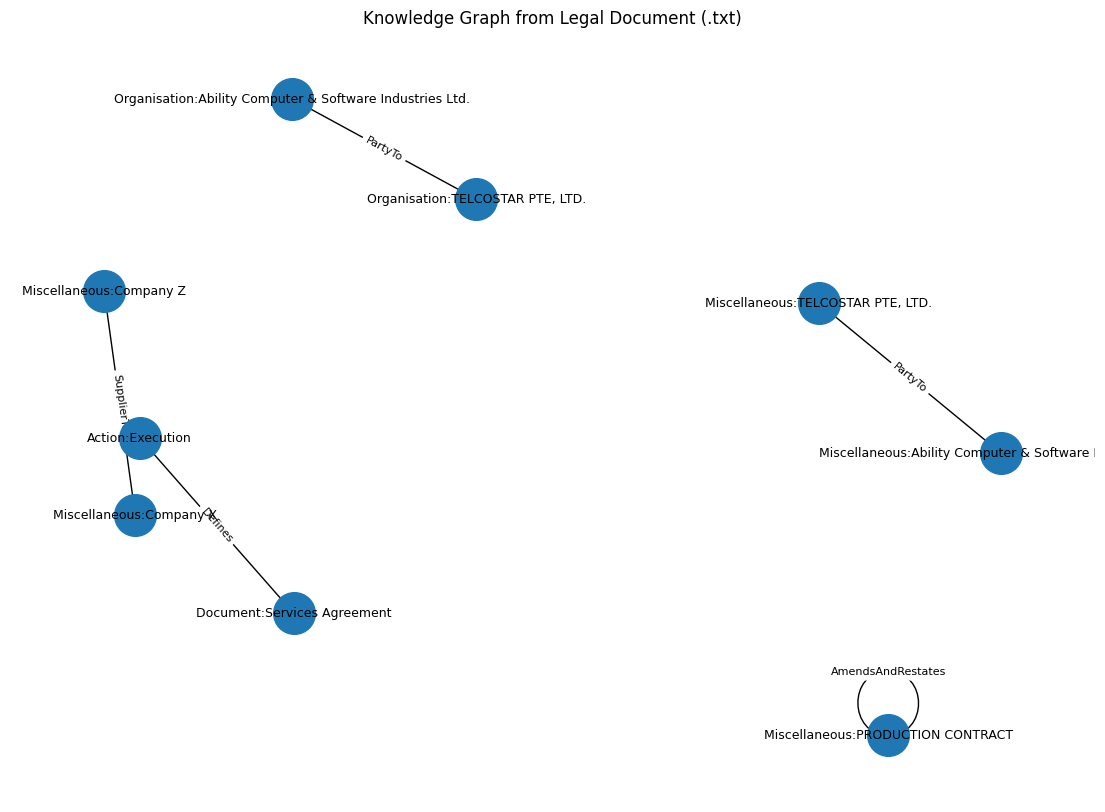

In [ ]:
# -*- coding: utf-8 -*-


!pip -q install knowledge-graph-maker transformers accelerate

from google.colab import userdata, files
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from knowledge_graph_maker import Ontology, Document
import torch, json, re, datetime
import networkx as nx
import matplotlib.pyplot as plt


hf_token = userdata.get("hack-ai")
if hf_token:
    print(f"Hugging Face token loaded: {hf_token[:8]}...")
else:
    print("HF token not found. In a separate cell, run:")
    print("from google.colab import userdata; userdata.set('hack-ai','<your_hf_token>')")

model_name = "tiiuae/Falcon3-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    torch_dtype=torch.bfloat16
)

# deterministic generation to reduce malformed JSON
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.0,
    top_p=1.0
)

class HuggingFaceClient:
    def __init__(self, generator):
        self.generator = generator

    def generate(self, user_message, system_message=""):
        prompt = f"""{system_message}

Return ONLY a JSON array. Use DOUBLE-QUOTED keys. Example:

[
  {{
    "node_1": {{"label":"Organisation","name":"TELCOSTAR PTE, LTD."}},
    "node_2": {{"label":"Organisation","name":"Ability Computer & Software Industries Ltd."}},
    "relationship": "PartyTo",
    "description": "Both are parties to the Services Agreement."
  }}
]

User: {user_message}
Assistant:"""
        out = self.generator(prompt, do_sample=False)
        text = out[0]["generated_text"]
        return text.split("Assistant:")[-1].strip()

llm = HuggingFaceClient(generator)

ontology = Ontology(
    labels=[
        {"Party": "A legal entity involved in the agreement (individual or organization)."},
        {"Obligation": "A duty or responsibility imposed on a Party under this Agreement."},
        {"Right": "A legal right or entitlement held by a Party."},
        {"Clause": "A numbered or named section of the Agreement."},
        {"Date": "Dates referenced in the Agreement."},
        {"Amount": "Monetary amounts, fees, or penalties."},
        {"Service": "Specific service or deliverable provided under the Agreement."},
        {"Condition": "Conditions that trigger obligations, rights, or termination."},
        {"ConfidentialInfo": "Information marked as confidential in the Agreement."},
        {"Miscellaneous": "Other important concepts not covered by above categories."}
    ],
    relationships=[
        "Party has Obligation",
        "Party holds Right",
        "Clause references Clause",
        "Condition triggers Obligation/Right",
        "Party responsible for Service",
        "Party pays Amount",
        "Party protected by ConfidentialInfo"
    ]
)

ALLOWED_LABELS = {"Person","Object","Event","Place","Document","Organisation","Action","Miscellaneous"}

def _quote_unquoted_keys(s: str) -> str:
    return re.sub(r'(?P<sep>[{,\s])(?P<key>[A-Za-z_]\w*)\s*:', r'\g<sep>"\g<key>":', s)

def _strip_trailing_commas(s: str) -> str:
    return re.sub(r',\s*([}\]])', r'\1', s)

def _force_array(s: str) -> str:
    t = s.strip()
    if t.startswith('{') and t.endswith('}'):
        return f'[{t}]'
    return t

def extract_json_edges(output_str):
    cleaned = output_str.replace('<|assistant|>', '').strip()
    cleaned = _quote_unquoted_keys(cleaned)
    cleaned = _strip_trailing_commas(cleaned)
    cleaned = _force_array(cleaned)

    try:
        parsed = json.loads(cleaned)
        if isinstance(parsed, dict):
            parsed = [parsed]
        if isinstance(parsed, list):
            return parsed
    except json.JSONDecodeError:
        pass

    objs = re.findall(r'\{.*?\}(?=\s*(?:\{|\]|$))', cleaned, flags=re.DOTALL)
    edges = []
    for obj in objs:
        try:
            edges.append(json.loads(_strip_trailing_commas(_quote_unquoted_keys(obj))))
        except json.JSONDecodeError:
            continue
    return edges

def _normalize_label(label: str) -> str:
    if not label:
        return "Miscellaneous"
    role_to_org = {"Provider","Recipient","Subcontractor","Party","Parties","Provider Representatives"}
    norm = label.strip()
    if norm in role_to_org:
        return "Organisation"

    titleish = norm.strip().title()
    return titleish if titleish in ALLOWED_LABELS else ("Organisation" if norm in role_to_org else ("Miscellaneous" if norm not in ALLOWED_LABELS else norm))

def _is_generic_name(name: str) -> bool:
    return name.strip().lower() in {"provider","recipient","subcontractor","party","parties","provider representatives","services agreement"}

def sanitize_edges(edges_raw):
    sanitized, seen = [], set()
    for e in edges_raw:
        if not isinstance(e, dict):
            continue
        n1, n2 = e.get("node_1"), e.get("node_2")
        rel = e.get("relationship") or e.get("relation") or e.get("edge")
        if not rel and isinstance(n1, dict) and "relationship" in n1:
            rel = n1.pop("relationship", None)
        if not (isinstance(n1, dict) and isinstance(n2, dict) and isinstance(rel, str) and rel.strip()):
            continue

        l1 = _normalize_label(n1.get("label"))
        l2 = _normalize_label(n2.get("label"))
        name1 = (n1.get("name") or "").strip()
        name2 = (n2.get("name") or "").strip()
        if not name1 or not name2:
            continue
        if _is_generic_name(name1) and _is_generic_name(name2):
            continue

        edge = {
            "node_1": {"label": l1, "name": name1},
            "node_2": {"label": l2, "name": name2},
            "relationship": rel.strip(),
        }
        desc = e.get("description")
        if isinstance(desc, str) and desc.strip():
            edge["description"] = desc.strip()

        key = (edge["node_1"]["label"], edge["node_1"]["name"],
               edge["node_2"]["label"], edge["node_2"]["name"], edge["relationship"])
        if key in seen:
            continue
        seen.add(key)
        sanitized.append(edge)
    return sanitized

def generate_edges(text, max_retries=2):
    SYS_PROMPT = (
        "Extract a knowledge graph from the text. "
        "Return ONLY a JSON array of edges. "
        "Each edge MUST have keys: "
        "\"node_1\" (obj with \"label\",\"name\"), "
        "\"node_2\" (obj with \"label\",\"name\"), "
        "\"relationship\" (string), and optional \"description\"."
    )
    for _ in range(max_retries + 1):
        raw = llm.generate(user_message=text, system_message=SYS_PROMPT)
        edges_raw = extract_json_edges(raw)
        edges = sanitize_edges(edges_raw)
        if edges:
            return edges
    return []


print("Please upload your .txt file (the legal document).")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print(f"Received: {filename}")

with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    full_text = f.read()


def chunk_text(s, chunk_size=1800, overlap=200):
    chunks = []
    start, n = 0, len(s)
    while start < n:
        end = min(start + chunk_size, n)
        chunks.append(s[start:end])
        if end == n:
            break
        start = max(0, end - overlap)
    return chunks

chunks = chunk_text(full_text, chunk_size=1800, overlap=200)
print(f"Text length: {len(full_text):,} chars | Chunks: {len(chunks)}")

current_time = str(datetime.datetime.now())
docs = [Document(text=ch, metadata={"generated_at": current_time}) for ch in chunks]


print("Creating knowledge graph from uploaded document (sanitized, no internal LLM calls)...")
all_edges = []
for d in docs:
    d.metadata["edges"] = generate_edges(d.text)
    all_edges.extend(d.metadata["edges"])

# Optional: seed a couple of deterministic edges (common for legal docs)
if "Services Agreement" in full_text or "This Services Agreement" in full_text:
    seed = {
        "node_1": {"label":"Document","name":"Services Agreement"},
        "node_2": {"label":"Action","name":"Execution"},
        "relationship": "Defines"
    }
    key_seed = (seed['node_1']['label'], seed['node_1']['name'],
                seed['node_2']['label'], seed['node_2']['name'], seed['relationship'])
    exist = {(e['node_1']['label'], e['node_1']['name'],
              e['node_2']['label'], e['node_2']['name'], e['relationship']) for e in all_edges}
    if key_seed not in exist:
        all_edges.append(seed)

print("✅ Total number of edges:", len(all_edges))
for e in all_edges[:10]:
    print(e, "\n")

# =========================
# Step 7 — Visualize
# =========================
G = nx.DiGraph()
for e in all_edges:
    n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
    n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
    rel = e["relationship"]
    G.add_node(n1)
    G.add_node(n2)
    G.add_edge(n1, n2, relationship=rel)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.8, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=900)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)},
    font_size=8
)
plt.axis('off')
plt.title("Knowledge Graph from Legal Document (.txt)")
plt.show()

## Trial 3 - Final Code Implementation (without UI)


To be able to view the UI please run this then run final UI section below

Hugging Face token loaded: hf_XfuFW...


Device set to use cuda:0


📄 Please upload your .txt file (the legal document).


Saving CUROGROUPHOLDINGSCORP_05_04_2020-EX-10.3-SERVICING%20AGREEMENT.txt to CUROGROUPHOLDINGSCORP_05_04_2020-EX-10.3-SERVICING%20AGREEMENT.txt
Received: CUROGROUPHOLDINGSCORP_05_04_2020-EX-10.3-SERVICING%20AGREEMENT.txt
Text length: 36,602 chars | Chunks: 36
✨ Creating knowledge graph (LLM-only; no rule-based seeds)...
✅ LLM edges (per-chunk) total: 19


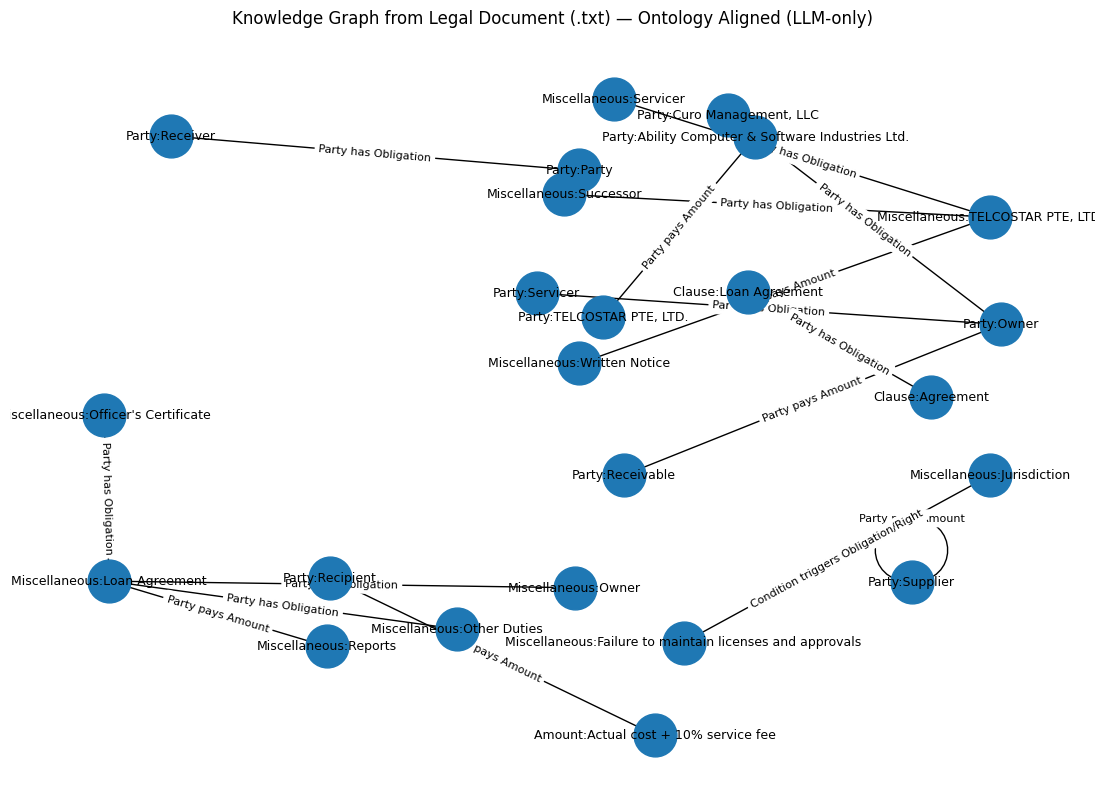


Sample edges:

{'node_1': {'label': 'Party', 'name': 'Curo Management, LLC'}, 'node_2': {'label': 'Party', 'name': 'Owner'}, 'relationship': 'Party has Obligation', 'description': 'The Servicer agrees to act as an independent contractor for the Owner.'} 

{'node_1': {'label': 'Party', 'name': 'Receivable'}, 'node_2': {'label': 'Party', 'name': 'Owner'}, 'relationship': 'Party pays Amount', 'description': 'Payment terms specified in the Serviced Asset contract.'} 

{'node_1': {'label': 'Party', 'name': 'Servicer'}, 'node_2': {'label': 'Party', 'name': 'Owner'}, 'relationship': 'Party has Obligation', 'description': 'The Servicer agrees to comply with the Servicing Standard.'} 

{'node_1': {'label': 'Party', 'name': 'Party'}, 'node_2': {'label': 'Party', 'name': 'Receiver'}, 'relationship': 'Party has Obligation', 'description': 'The Receiver acknowledges receipt and adequacy of consideration.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'Owner'}, 'node_2': {'label': 'Miscellaneous

In [ ]:
# -*- coding: utf-8 -*-
# Import Libraries
!pip -q install knowledge-graph-maker transformers accelerate

from google.colab import userdata, files
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from knowledge_graph_maker import Ontology, Document
import torch, json, re, datetime, io, sys
import networkx as nx
import matplotlib.pyplot as plt

# Load model
hf_token = userdata.get("hack-ai")
if hf_token:
    print(f"Hugging Face token loaded: {hf_token[:8]}...")
else:
    print("HF token not found. In a separate cell, run:")
    print("from google.colab import userdata; userdata.set('hack-ai','<your_hf_token>')")

model_name = "tiiuae/Falcon3-1B-Instruct"


dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token, trust_remote_code=True)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    torch_dtype=dtype,
    trust_remote_code=True,
    device_map="auto",
)


if getattr(model.generation_config, "pad_token_id", None) is None:
    model.generation_config.pad_token_id = tokenizer.pad_token_id

# Deterministic generation
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=dtype,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.05
)

# Prompt Template
class HuggingFaceClient:
    def __init__(self, generator):
        self.generator = generator

    def generate(self, user_message, system_message=""):
        prompt = f"""{system_message}

Return ONLY a JSON array. Use DOUBLE-QUOTED keys. Emit AT LEAST 4 edges per chunk.
Use labels ONLY from: ["Party","Obligation","Right","Clause","Date","Amount","Service","Condition","ConfidentialInfo","Miscellaneous"].
Use relationships ONLY from: ["Party has Obligation","Party holds Right","Clause references Clause","Condition triggers Obligation/Right","Party responsible for Service","Party pays Amount","Party protected by ConfidentialInfo"].
Prefer concrete names (e.g., company names, dates, amounts) over generic placeholders.

Valid edge schema:
[
  {{
    "node_1": {{"label":"Party","name":"TELCOSTAR PTE, LTD."}},
    "node_2": {{"label":"Party","name":"Ability Computer & Software Industries Ltd."}},
    "relationship": "Party has Obligation",
    "description": "Each party has duties under the Services Agreement."
  }},
  {{
    "node_1": {{"label":"Clause","name":"Services Agreement"}},
    "node_2": {{"label":"Date","name":"Effective Date: November 1, 2019"}},
    "relationship": "Clause references Clause"
  }},
  {{
    "node_1": {{"label":"Party","name":"Recipient"}},
    "node_2": {{"label":"Amount","name":"Actual cost + 10% service fee"}},
    "relationship": "Party pays Amount",
    "description": "Monthly invoices payable within 15 days."
  }}
]

Guidelines:
- If the text mentions “Effective Date”, output it as a Date node.
- If the text mentions payment terms or setoff, map to “Party pays Amount”.
- If the text mentions services delivered, map to “Party responsible for Service”.
- If the text mentions confidentiality, map to “Party protected by ConfidentialInfo”.
- If the text mentions termination conditions or acceptance/rejection windows, use “Condition triggers Obligation/Right”.
- Use “Clause references Clause” when a section references another section or legal concept.

User: {user_message}
Assistant:"""
        out = self.generator(
            prompt,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            return_full_text=False
        )
        text = out[0]["generated_text"]

        return text.strip()

llm = HuggingFaceClient(generator)


# Oncology (Structure of the graph)
ontology = Ontology(
    labels=[
        {"Party": "A legal entity involved in the agreement (individual or organization)."},
        {"Obligation": "A duty or responsibility imposed on a Party under this Agreement."},
        {"Right": "A legal right or entitlement held by a Party."},
        {"Clause": "A numbered or named section of the Agreement."},
        {"Date": "Dates referenced in the Agreement."},
        {"Amount": "Monetary amounts, fees, or penalties."},
        {"Service": "Specific service or deliverable provided under the Agreement."},
        {"Condition": "Conditions that trigger obligations, rights, or termination."},
        {"ConfidentialInfo": "Information marked as confidential in the Agreement."},
        {"Miscellaneous": "Other important concepts not covered by above categories."}
    ],
    relationships=[
        "Party has Obligation",
        "Party holds Right",
        "Clause references Clause",
        "Condition triggers Obligation/Right",
        "Party responsible for Service",
        "Party pays Amount",
        "Party protected by ConfidentialInfo"
    ]
)

def _labels_from_ontology(ont: Ontology):
    allowed = set()
    for item in ont.labels:
        if isinstance(item, str):
            allowed.add(item)
        elif isinstance(item, dict):
            allowed.update(item.keys())
    return allowed

ALLOWED_LABELS = _labels_from_ontology(ontology)
ALLOWED_RELATIONSHIPS = {
    "Party has Obligation",
    "Party holds Right",
    "Clause references Clause",
    "Condition triggers Obligation/Right",
    "Party responsible for Service",
    "Party pays Amount",
    "Party protected by ConfidentialInfo",
}

# Common alias mapping : legal ontology labels (used to process the output to have consistent naming of the labels)
ALIAS_TO_LABEL = {

    "provider": "Party", "recipient": "Party", "subcontractor": "Party",
    "party": "Party", "parties": "Party", "company": "Party",
    "organization": "Party", "organisation": "Party",

    "agreement": "Clause", "contract": "Clause", "services agreement": "Clause",
    "exhibit": "Clause", "section": "Clause", "clause": "Clause",

    "effective date": "Date", "date": "Date",
    "fee": "Amount", "fees": "Amount", "amount": "Amount", "payment": "Amount",
    "service": "Service",
    "confidential information": "ConfidentialInfo", "confidentialinfo": "ConfidentialInfo",
    "condition": "Condition", "obligation": "Obligation", "right": "Right",
}

# Json Parser
def _quote_unquoted_keys(s: str) -> str:
    return re.sub(r'(?P<sep>[{,\s])(?P<key>[A-Za-z_]\w*)\s*:', r'\g<sep>"\g<key>":', s)

def _strip_trailing_commas(s: str) -> str:
    return re.sub(r',\s*([}\]])', r'\1', s)

def _strip_code_fences(s: str) -> str:
    t = s.strip()
    t = re.sub(r"^```(?:json)?\s*", "", t)
    t = re.sub(r"\s*```$", "", t)
    return t

def _force_array(s: str) -> str:
    t = s.strip()
    if t.startswith('{') and t.endswith('}'):
        return f'[{t}]'
    return t

def extract_json_edges(output_str):
    cleaned = output_str.replace('<|assistant|>', '').strip()
    cleaned = _strip_code_fences(cleaned)
    cleaned = _quote_unquoted_keys(cleaned)
    cleaned = _strip_trailing_commas(cleaned)
    cleaned = _force_array(cleaned)


    try:
        parsed = json.loads(cleaned)
        if isinstance(parsed, dict):
            parsed = [parsed]
        if isinstance(parsed, list):
            return parsed
    except json.JSONDecodeError:
        pass

    objs = re.findall(r'\{.*?\}(?=\s*(?:\{|\]|$))', cleaned, flags=re.DOTALL)
    edges = []
    for obj in objs:
        try:
            edges.append(json.loads(_strip_trailing_commas(_quote_unquoted_keys(obj))))
        except json.JSONDecodeError:
            continue
    return edges

def _canonicalize_label(raw_label: str) -> str:
    if not raw_label:
        return "Miscellaneous"
    key = raw_label.strip().lower()
    if key in ALIAS_TO_LABEL:
        return ALIAS_TO_LABEL[key]
    if raw_label in ALLOWED_LABELS:
        return raw_label
    for lab in ALLOWED_LABELS:
        if lab.lower() == key:
            return lab
    return "Miscellaneous"

GENERIC_NAMES = {
    "provider","recipient","subcontractor","party","parties",
    "services agreement","agreement","clause","section","exhibit"
}

def _is_generic_name(name: str) -> bool:
    return (name or "").strip().lower() in GENERIC_NAMES

def _map_relationship(rel: str) -> str:
    """Coerce common phrasing into allowed relationships."""
    r = (rel or "").strip()
    if r in ALLOWED_RELATIONSHIPS:
        return r
    low = r.lower()
    if any(k in low for k in ["pay","invoice","fee","reimburse","amount"]):
        return "Party pays Amount"
    if any(k in low for k in ["obligation","shall","must","responsible","provide"]):
        return "Party has Obligation"
    if ("right" in low) or ("entitled" in low) or ("may" in low and "terminate" in low):
        return "Party holds Right"
    if any(k in low for k in ["confidential","confidentiality","non-disclosure"]):
        return "Party protected by ConfidentialInfo"
    if any(k in low for k in ["service","perform","provide","deliver"]):
        return "Party responsible for Service"
    if any(k in low for k in ["condition","force majeure","upon","if","accept","reject","notice"]):
        return "Condition triggers Obligation/Right"
    if any(k in low for k in ["clause","section","exhibit","agreement","references"]):
        return "Clause references Clause"
    return "Party has Obligation"

def sanitize_edges(edges_raw):
    """Validate edges and coerce labels/relationships to the ontology."""
    sanitized, seen = [], set()
    for e in edges_raw:
        if not isinstance(e, dict):
            continue
        n1, n2 = e.get("node_1"), e.get("node_2")
        rel = e.get("relationship") or e.get("relation") or e.get("edge")
        if not (isinstance(n1, dict) and isinstance(n2, dict) and isinstance(rel, str) and rel.strip()):
            continue

        l1 = _canonicalize_label(n1.get("label"))
        l2 = _canonicalize_label(n2.get("label"))
        name1 = (n1.get("name") or "").strip()
        name2 = (n2.get("name") or "").strip()
        if not name1 or not name2:
            continue


        if _is_generic_name(name1) and _is_generic_name(name2):
            if not (l1 in {"Clause","Date","Amount","Service"} or l2 in {"Clause","Date","Amount","Service"}):
                continue

        mapped_rel = _map_relationship(rel)
        edge = {
            "node_1": {"label": l1, "name": name1},
            "node_2": {"label": l2, "name": name2},
            "relationship": mapped_rel,
        }
        desc = e.get("description")
        if isinstance(desc, str) and desc.strip():
            edge["description"] = desc.strip()

        key = (edge["node_1"]["label"], edge["node_1"]["name"],
               edge["node_2"]["label"], edge["node_2"]["name"], edge["relationship"])
        if key in seen:
            continue
        seen.add(key)
        sanitized.append(edge)
    return sanitized

def generate_edges(text, min_edges=3, max_retries=2):
    """LLM-only edge extraction for a text chunk."""
    SYS_PROMPT = ("You are lawyer that understands correlations between parties."
        "Extract a knowledge graph from the text. "
        "Return ONLY a JSON array of edges. Emit AT LEAST 4 edges. "
        "Each edge MUST have keys: "
        "\"node_1\" (obj with \"label\",\"name\"), "
        "\"node_2\" (obj with \"label\",\"name\"), "
        "\"relationship\" (string), and optional \"description\". "
        f"Use ONLY these labels: {sorted(list(ALLOWED_LABELS))}. "
        f"Use ONLY these relationships (closest fit if needed): {sorted(list(ALLOWED_RELATIONSHIPS))}. "
        "Prefer concrete entity names (company names, dates, amounts)."
    )
    last_raw = ""
    for _ in range(max_retries + 1):
        last_raw = llm.generate(user_message=text, system_message=SYS_PROMPT)
        edges_raw = extract_json_edges(last_raw)
        edges = sanitize_edges(edges_raw)
        if len(edges) >= min_edges:
            return edges
    return sanitize_edges(extract_json_edges(last_raw))

# Upload text file
print("Please upload your .txt file (the legal document).")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print(f"Received: {filename}")

with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    full_text = f.read()

# Split the text into chunks
def chunk_text(s, chunk_size=1400, overlap=200):
    chunks = []
    start, n = 0, len(s)
    while start < n:
        end = min(start + chunk_size, n)

        segment = s[start:end]
        dot = segment.rfind(".")
        if dot != -1 and end != n and dot > chunk_size * 0.6:
            end = start + dot + 1
            segment = s[start:end]
        chunks.append(segment)
        if end == n:
            break
        start = max(0, end - overlap)
    return chunks

chunks = chunk_text(full_text, chunk_size=1400, overlap=220)
print(f"Text length: {len(full_text):,} chars | Chunks: {len(chunks)}")

current_time = str(datetime.datetime.now())
docs = [Document(text=ch, metadata={"generated_at": current_time, "chunk_index": i}) for i, ch in enumerate(chunks)]

# Generate Edges
print("Creating knowledge graph (LLM-only; no rule-based seeds)...")
all_edges = []


for i, d in enumerate(docs):
    edges_i = generate_edges(d.text, min_edges=2, max_retries=2)
    d.metadata["edges"] = edges_i
    all_edges.extend(edges_i)
print(f"LLM edges (per-chunk) total: {len(all_edges)}")


MIN_TOTAL = 8
if len(all_edges) < MIN_TOTAL:
    print("Fallback: running on full document to boost edge coverage...")
    full_edges = generate_edges(full_text, min_edges=MIN_TOTAL, max_retries=2)

    def key_of(e):
        return (e['node_1']['label'], e['node_1']['name'],
                e['node_2']['label'], e['node_2']['name'], e['relationship'])
    seen = {key_of(e) for e in all_edges}
    added = 0
    for e in full_edges:
        k = key_of(e)
        if k not in seen:
            all_edges.append(e); seen.add(k); added += 1
    print(f"Added from full-doc pass: {added} | New total: {len(all_edges)}")

if len(all_edges) == 0:
    print("Still 0 edges. Try larger max_new_tokens, larger chunks, or a different base model.")

# Visualize
G = nx.DiGraph()
for e in all_edges:
    n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
    n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
    rel = e["relationship"]
    G.add_node(n1); G.add_node(n2)
    G.add_edge(n1, n2, relationship=rel)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.85, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=950)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True)
if G.number_of_edges() > 0:
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)},
        font_size=8
    )
plt.axis('off')
plt.title("Knowledge Graph from Legal Document (.txt) — Ontology Aligned (LLM-only)")
plt.show()

print("\nSample edges:\n")
for e in all_edges[:10]:
    print(e, "\n")


## Trial 3 - Tested on new txt file

Hugging Face token loaded: hf_XfuFW...


Device set to use cuda:0


📄 Please upload your .txt file (the legal document).


Saving CYBERIANOUTPOSTINC_07_09_1998-EX-10.13-PROMOTION%20AGREEMENT.txt to CYBERIANOUTPOSTINC_07_09_1998-EX-10.13-PROMOTION%20AGREEMENT.txt
Received: CYBERIANOUTPOSTINC_07_09_1998-EX-10.13-PROMOTION%20AGREEMENT.txt
Text length: 25,288 chars | Chunks: 24
✨ Creating knowledge graph (LLM-only; no rule-based seeds)...
✅ LLM edges (per-chunk) total: 15


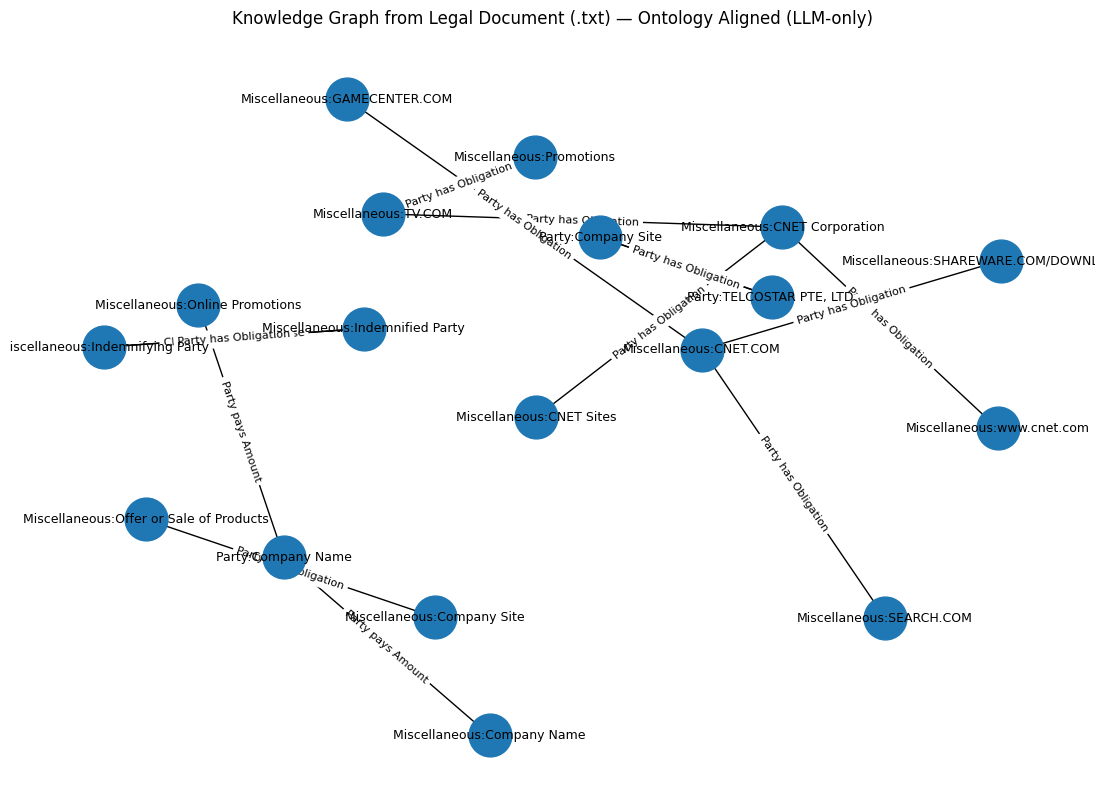


Sample edges:

{'node_1': {'label': 'Miscellaneous', 'name': 'CNET Corporation'}, 'node_2': {'label': 'Miscellaneous', 'name': 'www.cnet.com'}, 'relationship': 'Party has Obligation', 'description': 'CNET operates Internet sites for selling products and facilitating sales.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'CNET Sites'}, 'node_2': {'label': 'Miscellaneous', 'name': 'CNET Corporation'}, 'relationship': 'Party has Obligation', 'description': "CNET operates Internet sites under CNET's umbrella."} 

{'node_1': {'label': 'Miscellaneous', 'name': 'TV.COM'}, 'node_2': {'label': 'Miscellaneous', 'name': 'CNET Corporation'}, 'relationship': 'Party has Obligation', 'description': 'CNET provides spot advertising for TV.COM.'} 

{'node_1': {'label': 'Miscellaneous', 'name': 'Promotions'}, 'node_2': {'label': 'Miscellaneous', 'name': 'TV.COM'}, 'relationship': 'Party has Obligation', 'description': 'CNET runs 15-second spots on TV.COM during the Term.'} 

{'node_1': {'label': 'Part

In [ ]:
# -*- coding: utf-8 -*-
# Import Libraries
!pip -q install knowledge-graph-maker transformers accelerate

from google.colab import userdata, files
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from knowledge_graph_maker import Ontology, Document
import torch, json, re, datetime, io, sys
import networkx as nx
import matplotlib.pyplot as plt

# Load model
hf_token = userdata.get("hack-ai")
if hf_token:
    print(f"Hugging Face token loaded: {hf_token[:8]}...")
else:
    print("HF token not found. In a separate cell, run:")
    print("from google.colab import userdata; userdata.set('hack-ai','<your_hf_token>')")

model_name = "tiiuae/Falcon3-1B-Instruct"


dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token, trust_remote_code=True)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    torch_dtype=dtype,
    trust_remote_code=True,
    device_map="auto",
)


if getattr(model.generation_config, "pad_token_id", None) is None:
    model.generation_config.pad_token_id = tokenizer.pad_token_id

# Deterministic generation
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=dtype,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.05
)

# Prompt Template
class HuggingFaceClient:
    def __init__(self, generator):
        self.generator = generator

    def generate(self, user_message, system_message=""):
        prompt = f"""{system_message}

Return ONLY a JSON array. Use DOUBLE-QUOTED keys. Emit AT LEAST 4 edges per chunk.
Use labels ONLY from: ["Party","Obligation","Right","Clause","Date","Amount","Service","Condition","ConfidentialInfo","Miscellaneous"].
Use relationships ONLY from: ["Party has Obligation","Party holds Right","Clause references Clause","Condition triggers Obligation/Right","Party responsible for Service","Party pays Amount","Party protected by ConfidentialInfo"].
Prefer concrete names (e.g., company names, dates, amounts) over generic placeholders.

Valid edge schema:
[
  {{
    "node_1": {{"label":"Party","name":"TELCOSTAR PTE, LTD."}},
    "node_2": {{"label":"Party","name":"Ability Computer & Software Industries Ltd."}},
    "relationship": "Party has Obligation",
    "description": "Each party has duties under the Services Agreement."
  }},
  {{
    "node_1": {{"label":"Clause","name":"Services Agreement"}},
    "node_2": {{"label":"Date","name":"Effective Date: November 1, 2019"}},
    "relationship": "Clause references Clause"
  }},
  {{
    "node_1": {{"label":"Party","name":"Recipient"}},
    "node_2": {{"label":"Amount","name":"Actual cost + 10% service fee"}},
    "relationship": "Party pays Amount",
    "description": "Monthly invoices payable within 15 days."
  }}
]

Guidelines:
- If the text mentions “Effective Date”, output it as a Date node.
- If the text mentions payment terms or setoff, map to “Party pays Amount”.
- If the text mentions services delivered, map to “Party responsible for Service”.
- If the text mentions confidentiality, map to “Party protected by ConfidentialInfo”.
- If the text mentions termination conditions or acceptance/rejection windows, use “Condition triggers Obligation/Right”.
- Use “Clause references Clause” when a section references another section or legal concept.

User: {user_message}
Assistant:"""
        out = self.generator(
            prompt,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            return_full_text=False
        )
        text = out[0]["generated_text"]

        return text.strip()

llm = HuggingFaceClient(generator)


# Oncology (Structure of the graph)
ontology = Ontology(
    labels=[
        {"Party": "A legal entity involved in the agreement (individual or organization)."},
        {"Obligation": "A duty or responsibility imposed on a Party under this Agreement."},
        {"Right": "A legal right or entitlement held by a Party."},
        {"Clause": "A numbered or named section of the Agreement."},
        {"Date": "Dates referenced in the Agreement."},
        {"Amount": "Monetary amounts, fees, or penalties."},
        {"Service": "Specific service or deliverable provided under the Agreement."},
        {"Condition": "Conditions that trigger obligations, rights, or termination."},
        {"ConfidentialInfo": "Information marked as confidential in the Agreement."},
        {"Miscellaneous": "Other important concepts not covered by above categories."}
    ],
    relationships=[
        "Party has Obligation",
        "Party holds Right",
        "Clause references Clause",
        "Condition triggers Obligation/Right",
        "Party responsible for Service",
        "Party pays Amount",
        "Party protected by ConfidentialInfo"
    ]
)

def _labels_from_ontology(ont: Ontology):
    allowed = set()
    for item in ont.labels:
        if isinstance(item, str):
            allowed.add(item)
        elif isinstance(item, dict):
            allowed.update(item.keys())
    return allowed

ALLOWED_LABELS = _labels_from_ontology(ontology)
ALLOWED_RELATIONSHIPS = {
    "Party has Obligation",
    "Party holds Right",
    "Clause references Clause",
    "Condition triggers Obligation/Right",
    "Party responsible for Service",
    "Party pays Amount",
    "Party protected by ConfidentialInfo",
}

# Common alias mapping : legal ontology labels (used to process the output to have consistent naming of the labels)
ALIAS_TO_LABEL = {

    "provider": "Party", "recipient": "Party", "subcontractor": "Party",
    "party": "Party", "parties": "Party", "company": "Party",
    "organization": "Party", "organisation": "Party",

    "agreement": "Clause", "contract": "Clause", "services agreement": "Clause",
    "exhibit": "Clause", "section": "Clause", "clause": "Clause",

    "effective date": "Date", "date": "Date",
    "fee": "Amount", "fees": "Amount", "amount": "Amount", "payment": "Amount",
    "service": "Service",
    "confidential information": "ConfidentialInfo", "confidentialinfo": "ConfidentialInfo",
    "condition": "Condition", "obligation": "Obligation", "right": "Right",
}

# Json Parser
def _quote_unquoted_keys(s: str) -> str:
    return re.sub(r'(?P<sep>[{,\s])(?P<key>[A-Za-z_]\w*)\s*:', r'\g<sep>"\g<key>":', s)

def _strip_trailing_commas(s: str) -> str:
    return re.sub(r',\s*([}\]])', r'\1', s)

def _strip_code_fences(s: str) -> str:
    t = s.strip()
    t = re.sub(r"^```(?:json)?\s*", "", t)
    t = re.sub(r"\s*```$", "", t)
    return t

def _force_array(s: str) -> str:
    t = s.strip()
    if t.startswith('{') and t.endswith('}'):
        return f'[{t}]'
    return t

def extract_json_edges(output_str):
    cleaned = output_str.replace('<|assistant|>', '').strip()
    cleaned = _strip_code_fences(cleaned)
    cleaned = _quote_unquoted_keys(cleaned)
    cleaned = _strip_trailing_commas(cleaned)
    cleaned = _force_array(cleaned)


    try:
        parsed = json.loads(cleaned)
        if isinstance(parsed, dict):
            parsed = [parsed]
        if isinstance(parsed, list):
            return parsed
    except json.JSONDecodeError:
        pass

    objs = re.findall(r'\{.*?\}(?=\s*(?:\{|\]|$))', cleaned, flags=re.DOTALL)
    edges = []
    for obj in objs:
        try:
            edges.append(json.loads(_strip_trailing_commas(_quote_unquoted_keys(obj))))
        except json.JSONDecodeError:
            continue
    return edges

def _canonicalize_label(raw_label: str) -> str:
    if not raw_label:
        return "Miscellaneous"
    key = raw_label.strip().lower()
    if key in ALIAS_TO_LABEL:
        return ALIAS_TO_LABEL[key]
    if raw_label in ALLOWED_LABELS:
        return raw_label
    for lab in ALLOWED_LABELS:
        if lab.lower() == key:
            return lab
    return "Miscellaneous"

GENERIC_NAMES = {
    "provider","recipient","subcontractor","party","parties",
    "services agreement","agreement","clause","section","exhibit"
}

def _is_generic_name(name: str) -> bool:
    return (name or "").strip().lower() in GENERIC_NAMES

def _map_relationship(rel: str) -> str:
    """Coerce common phrasing into allowed relationships."""
    r = (rel or "").strip()
    if r in ALLOWED_RELATIONSHIPS:
        return r
    low = r.lower()
    if any(k in low for k in ["pay","invoice","fee","reimburse","amount"]):
        return "Party pays Amount"
    if any(k in low for k in ["obligation","shall","must","responsible","provide"]):
        return "Party has Obligation"
    if ("right" in low) or ("entitled" in low) or ("may" in low and "terminate" in low):
        return "Party holds Right"
    if any(k in low for k in ["confidential","confidentiality","non-disclosure"]):
        return "Party protected by ConfidentialInfo"
    if any(k in low for k in ["service","perform","provide","deliver"]):
        return "Party responsible for Service"
    if any(k in low for k in ["condition","force majeure","upon","if","accept","reject","notice"]):
        return "Condition triggers Obligation/Right"
    if any(k in low for k in ["clause","section","exhibit","agreement","references"]):
        return "Clause references Clause"
    return "Party has Obligation"

def sanitize_edges(edges_raw):
    """Validate edges and coerce labels/relationships to the ontology."""
    sanitized, seen = [], set()
    for e in edges_raw:
        if not isinstance(e, dict):
            continue
        n1, n2 = e.get("node_1"), e.get("node_2")
        rel = e.get("relationship") or e.get("relation") or e.get("edge")
        if not (isinstance(n1, dict) and isinstance(n2, dict) and isinstance(rel, str) and rel.strip()):
            continue

        l1 = _canonicalize_label(n1.get("label"))
        l2 = _canonicalize_label(n2.get("label"))
        name1 = (n1.get("name") or "").strip()
        name2 = (n2.get("name") or "").strip()
        if not name1 or not name2:
            continue


        if _is_generic_name(name1) and _is_generic_name(name2):
            if not (l1 in {"Clause","Date","Amount","Service"} or l2 in {"Clause","Date","Amount","Service"}):
                continue

        mapped_rel = _map_relationship(rel)
        edge = {
            "node_1": {"label": l1, "name": name1},
            "node_2": {"label": l2, "name": name2},
            "relationship": mapped_rel,
        }
        desc = e.get("description")
        if isinstance(desc, str) and desc.strip():
            edge["description"] = desc.strip()

        key = (edge["node_1"]["label"], edge["node_1"]["name"],
               edge["node_2"]["label"], edge["node_2"]["name"], edge["relationship"])
        if key in seen:
            continue
        seen.add(key)
        sanitized.append(edge)
    return sanitized

def generate_edges(text, min_edges=3, max_retries=2):
    """LLM-only edge extraction for a text chunk."""
    SYS_PROMPT = (
        "Extract a knowledge graph from the text. "
        "Return ONLY a JSON array of edges. Emit AT LEAST 4 edges. "
        "Each edge MUST have keys: "
        "\"node_1\" (obj with \"label\",\"name\"), "
        "\"node_2\" (obj with \"label\",\"name\"), "
        "\"relationship\" (string), and optional \"description\". "
        f"Use ONLY these labels: {sorted(list(ALLOWED_LABELS))}. "
        f"Use ONLY these relationships (closest fit if needed): {sorted(list(ALLOWED_RELATIONSHIPS))}. "
        "Prefer concrete entity names (company names, dates, amounts)."
    )
    last_raw = ""
    for _ in range(max_retries + 1):
        last_raw = llm.generate(user_message=text, system_message=SYS_PROMPT)
        edges_raw = extract_json_edges(last_raw)
        edges = sanitize_edges(edges_raw)
        if len(edges) >= min_edges:
            return edges
    return sanitize_edges(extract_json_edges(last_raw))

# Upload text file
print("Please upload your .txt file (the legal document).")
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print(f"Received: {filename}")

with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    full_text = f.read()

# Split the text into chunks
def chunk_text(s, chunk_size=1400, overlap=200):
    chunks = []
    start, n = 0, len(s)
    while start < n:
        end = min(start + chunk_size, n)

        segment = s[start:end]
        dot = segment.rfind(".")
        if dot != -1 and end != n and dot > chunk_size * 0.6:
            end = start + dot + 1
            segment = s[start:end]
        chunks.append(segment)
        if end == n:
            break
        start = max(0, end - overlap)
    return chunks

chunks = chunk_text(full_text, chunk_size=1400, overlap=220)
print(f"Text length: {len(full_text):,} chars | Chunks: {len(chunks)}")

current_time = str(datetime.datetime.now())
docs = [Document(text=ch, metadata={"generated_at": current_time, "chunk_index": i}) for i, ch in enumerate(chunks)]

# Generate Edges
print("Creating knowledge graph (LLM-only; no rule-based seeds)...")
all_edges = []


for i, d in enumerate(docs):
    edges_i = generate_edges(d.text, min_edges=2, max_retries=2)
    d.metadata["edges"] = edges_i
    all_edges.extend(edges_i)
print(f"LLM edges (per-chunk) total: {len(all_edges)}")


MIN_TOTAL = 8
if len(all_edges) < MIN_TOTAL:
    print("Fallback: running on full document to boost edge coverage...")
    full_edges = generate_edges(full_text, min_edges=MIN_TOTAL, max_retries=2)

    def key_of(e):
        return (e['node_1']['label'], e['node_1']['name'],
                e['node_2']['label'], e['node_2']['name'], e['relationship'])
    seen = {key_of(e) for e in all_edges}
    added = 0
    for e in full_edges:
        k = key_of(e)
        if k not in seen:
            all_edges.append(e); seen.add(k); added += 1
    print(f"Added from full-doc pass: {added} | New total: {len(all_edges)}")

if len(all_edges) == 0:
    print("Still 0 edges. Try larger max_new_tokens, larger chunks, or a different base model.")

# Visualize
G = nx.DiGraph()
for e in all_edges:
    n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
    n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
    rel = e["relationship"]
    G.add_node(n1); G.add_node(n2)
    G.add_edge(n1, n2, relationship=rel)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.85, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=950)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True)
if G.number_of_edges() > 0:
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)},
        font_size=8
    )
plt.axis('off')
plt.title("Knowledge Graph from Legal Document (.txt) — Ontology Aligned (LLM-only)")
plt.show()

print("\nSample edges:\n")
for e in all_edges[:10]:
    print(e, "\n")


## User Interface on txt upload file

In [ ]:
# Gradio UI
!pip -q install gradio

import gradio as gr
from PIL import Image
from io import BytesIO
import os, uuid, textwrap



def build_graph_from_text(text: str):

    chunks_local = chunk_text(text, chunk_size=1400, overlap=220)

    all_edges_local = []
    for ch in chunks_local:
        all_edges_local.extend(generate_edges(ch, min_edges=2, max_retries=2))

    if len(all_edges_local) < 8:
        full_edges = generate_edges(text, min_edges=8, max_retries=2)
        def key_of(e):
            return (e['node_1']['label'], e['node_1']['name'],
                    e['node_2']['label'], e['node_2']['name'], e['relationship'])
        seen = {key_of(e) for e in all_edges_local}
        for e in full_edges:
            if key_of(e) not in seen:
                all_edges_local.append(e); seen.add(key_of(e))

    # Graph
    G_local = nx.DiGraph()
    for e in all_edges_local:
        n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
        n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
        rel = e["relationship"]
        G_local.add_node(n1); G_local.add_node(n2)
        G_local.add_edge(n1, n2, relationship=rel)
    return all_edges_local, G_local

def draw_graph_image(G_local) -> Image.Image:

    fig = plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G_local, k=0.85, seed=42)
    nx.draw_networkx_nodes(G_local, pos, node_size=950)
    nx.draw_networkx_labels(G_local, pos, font_size=9)
    nx.draw_networkx_edges(G_local, pos, arrows=True)
    if G_local.number_of_edges() > 0:
        nx.draw_networkx_edge_labels(
            G_local, pos,
            edge_labels={(u, v): d['relationship'] for u, v, d in G_local.edges(data=True)},
            font_size=8
        )
    plt.axis('off')
    plt.title("Knowledge Graph from Legal Document (.txt) — Ontology Aligned (LLM-only)")
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

def edges_preview_text(edges, max_items=12) -> str:
    lines = []
    for e in edges[:max_items]:
        n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
        n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
        rel = e['relationship']
        desc = e.get('description')
        line = f"• {n1}  --[{rel}]->  {n2}"
        if desc:
            line += f"\n    - {textwrap.shorten(desc, width=140)}"
        lines.append(line)
    if len(edges) > max_items:
        lines.append(f"\n… and {len(edges) - max_items} more edges.")
    return "\n".join(lines) if lines else "(No edges found.)"

def process_txt_file(file_obj):

    if file_obj is None:
        return None, "Please upload a .txt file.", None

    # Read
    with open(file_obj.name, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    # Build graph & edges
    edges, G_local = build_graph_from_text(text)

    # Render graph image
    img = draw_graph_image(G_local)

    os.makedirs("/content/graph_outputs", exist_ok=True)
    out_id = uuid.uuid4().hex[:8]
    json_path = f"/content/graph_outputs/edges_{out_id}.json"
    with open(json_path, "w", encoding="utf-8") as jf:
        json.dump(edges, jf, ensure_ascii=False, indent=2)

    preview = edges_preview_text(edges, max_items=12)
    return img, preview, json_path

with gr.Blocks(title="Legal KG Extractor") as demo:
    gr.Markdown(
        """
        # Legal Knowledge Graph Extractor (LLM-only, Ontology-Aligned)
        Upload a **.txt** legal document. The app extracts edges with your ontology,
        then renders a knowledge graph image. You can also download the raw **edges.json**.
        """
    )
    with gr.Row():
        with gr.Column():
            in_file = gr.File(label="Upload .txt", file_types=[".txt"])
            run_btn = gr.Button("Extract Graph")
        with gr.Column():
            out_img = gr.Image(label="Graph Image", type="pil")
            out_preview = gr.Textbox(label="Edge Preview", lines=16)
            out_json = gr.File(label="Download edges.json")

    run_btn.click(fn=process_txt_file, inputs=[in_file], outputs=[out_img, out_preview, out_json])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6959ccfaed1874eaf0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#Final Implementation (Code + Multi- modal UI: Txt File Upload, PDF File Upload, Image Upload, Text Input)

In [3]:
# -*- coding: utf-8 -*-
# Import Libraries
!pip -q install knowledge-graph-maker transformers accelerate

from google.colab import userdata, files
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from knowledge_graph_maker import Ontology, Document
import torch, json, re, datetime, io, sys
import networkx as nx
import matplotlib.pyplot as plt

# Load model
hf_token = userdata.get("hack-ai")
if hf_token:
    print(f"Hugging Face token loaded: {hf_token[:8]}...")
else:
    print("HF token not found. In a separate cell, run:")
    print("from google.colab import userdata; userdata.set('hack-ai','<your_hf_token>')")

model_name = "tiiuae/Falcon3-1B-Instruct"


dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token, trust_remote_code=True)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=hf_token,
    torch_dtype=dtype,
    trust_remote_code=True,
    device_map="auto",
)


if getattr(model.generation_config, "pad_token_id", None) is None:
    model.generation_config.pad_token_id = tokenizer.pad_token_id

# Deterministic generation
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=dtype,
    device_map="auto",
    max_new_tokens=512,
    temperature=0.0,
    top_p=1.0,
    repetition_penalty=1.05
)

# Prompt Template
class HuggingFaceClient:
    def __init__(self, generator):
        self.generator = generator

    def generate(self, user_message, system_message=""):
        prompt = f"""{system_message}

Return ONLY a JSON array. Use DOUBLE-QUOTED keys. Emit AT LEAST 4 edges per chunk.
Use labels ONLY from: ["Party","Obligation","Right","Clause","Date","Amount","Service","Condition","ConfidentialInfo","Miscellaneous"].
Use relationships ONLY from: ["Party has Obligation","Party holds Right","Clause references Clause","Condition triggers Obligation/Right","Party responsible for Service","Party pays Amount","Party protected by ConfidentialInfo"].
Prefer concrete names (e.g., company names, dates, amounts) over generic placeholders.

Valid edge schema:
[
  {{
    "node_1": {{"label":"Party","name":"TELCOSTAR PTE, LTD."}},
    "node_2": {{"label":"Party","name":"Ability Computer & Software Industries Ltd."}},
    "relationship": "Party has Obligation",
    "description": "Each party has duties under the Services Agreement."
  }},
  {{
    "node_1": {{"label":"Clause","name":"Services Agreement"}},
    "node_2": {{"label":"Date","name":"Effective Date: November 1, 2019"}},
    "relationship": "Clause references Clause"
  }},
  {{
    "node_1": {{"label":"Party","name":"Recipient"}},
    "node_2": {{"label":"Amount","name":"Actual cost + 10% service fee"}},
    "relationship": "Party pays Amount",
    "description": "Monthly invoices payable within 15 days."
  }}
]

Guidelines:
- If the text mentions “Effective Date”, output it as a Date node.
- If the text mentions payment terms or setoff, map to “Party pays Amount”.
- If the text mentions services delivered, map to “Party responsible for Service”.
- If the text mentions confidentiality, map to “Party protected by ConfidentialInfo”.
- If the text mentions termination conditions or acceptance/rejection windows, use “Condition triggers Obligation/Right”.
- Use “Clause references Clause” when a section references another section or legal concept.

User: {user_message}
Assistant:"""
        out = self.generator(
            prompt,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            return_full_text=False
        )
        text = out[0]["generated_text"]

        return text.strip()

llm = HuggingFaceClient(generator)


# Oncology (Structure of the graph)
ontology = Ontology(
    labels=[
        {"Party": "A legal entity involved in the agreement (individual or organization)."},
        {"Obligation": "A duty or responsibility imposed on a Party under this Agreement."},
        {"Right": "A legal right or entitlement held by a Party."},
        {"Clause": "A numbered or named section of the Agreement."},
        {"Date": "Dates referenced in the Agreement."},
        {"Amount": "Monetary amounts, fees, or penalties."},
        {"Service": "Specific service or deliverable provided under the Agreement."},
        {"Condition": "Conditions that trigger obligations, rights, or termination."},
        {"ConfidentialInfo": "Information marked as confidential in the Agreement."},
        {"Miscellaneous": "Other important concepts not covered by above categories."}
    ],
    relationships=[
        "Party has Obligation",
        "Party holds Right",
        "Clause references Clause",
        "Condition triggers Obligation/Right",
        "Party responsible for Service",
        "Party pays Amount",
        "Party protected by ConfidentialInfo"
    ]
)

def _labels_from_ontology(ont: Ontology):
    allowed = set()
    for item in ont.labels:
        if isinstance(item, str):
            allowed.add(item)
        elif isinstance(item, dict):
            allowed.update(item.keys())
    return allowed

ALLOWED_LABELS = _labels_from_ontology(ontology)
ALLOWED_RELATIONSHIPS = {
    "Party has Obligation",
    "Party holds Right",
    "Clause references Clause",
    "Condition triggers Obligation/Right",
    "Party responsible for Service",
    "Party pays Amount",
    "Party protected by ConfidentialInfo",
}

# Common alias mapping : legal ontology labels (used to process the output to have consistent naming of the labels)
ALIAS_TO_LABEL = {

    "provider": "Party", "recipient": "Party", "subcontractor": "Party",
    "party": "Party", "parties": "Party", "company": "Party",
    "organization": "Party", "organisation": "Party",

    "agreement": "Clause", "contract": "Clause", "services agreement": "Clause",
    "exhibit": "Clause", "section": "Clause", "clause": "Clause",

    "effective date": "Date", "date": "Date",
    "fee": "Amount", "fees": "Amount", "amount": "Amount", "payment": "Amount",
    "service": "Service",
    "confidential information": "ConfidentialInfo", "confidentialinfo": "ConfidentialInfo",
    "condition": "Condition", "obligation": "Obligation", "right": "Right",
}

# Json Parser
def _quote_unquoted_keys(s: str) -> str:
    return re.sub(r'(?P<sep>[{,\s])(?P<key>[A-Za-z_]\w*)\s*:', r'\g<sep>"\g<key>":', s)

def _strip_trailing_commas(s: str) -> str:
    return re.sub(r',\s*([}\]])', r'\1', s)

def _strip_code_fences(s: str) -> str:
    t = s.strip()
    t = re.sub(r"^```(?:json)?\s*", "", t)
    t = re.sub(r"\s*```$", "", t)
    return t

def _force_array(s: str) -> str:
    t = s.strip()
    if t.startswith('{') and t.endswith('}'):
        return f'[{t}]'
    return t

def extract_json_edges(output_str):
    cleaned = output_str.replace('<|assistant|>', '').strip()
    cleaned = _strip_code_fences(cleaned)
    cleaned = _quote_unquoted_keys(cleaned)
    cleaned = _strip_trailing_commas(cleaned)
    cleaned = _force_array(cleaned)


    try:
        parsed = json.loads(cleaned)
        if isinstance(parsed, dict):
            parsed = [parsed]
        if isinstance(parsed, list):
            return parsed
    except json.JSONDecodeError:
        pass

    objs = re.findall(r'\{.*?\}(?=\s*(?:\{|\]|$))', cleaned, flags=re.DOTALL)
    edges = []
    for obj in objs:
        try:
            edges.append(json.loads(_strip_trailing_commas(_quote_unquoted_keys(obj))))
        except json.JSONDecodeError:
            continue
    return edges

def _canonicalize_label(raw_label: str) -> str:
    if not raw_label:
        return "Miscellaneous"
    key = raw_label.strip().lower()
    if key in ALIAS_TO_LABEL:
        return ALIAS_TO_LABEL[key]
    if raw_label in ALLOWED_LABELS:
        return raw_label
    for lab in ALLOWED_LABELS:
        if lab.lower() == key:
            return lab
    return "Miscellaneous"

GENERIC_NAMES = {
    "provider","recipient","subcontractor","party","parties",
    "services agreement","agreement","clause","section","exhibit"
}

def _is_generic_name(name: str) -> bool:
    return (name or "").strip().lower() in GENERIC_NAMES

def _map_relationship(rel: str) -> str:
    """Coerce common phrasing into allowed relationships."""
    r = (rel or "").strip()
    if r in ALLOWED_RELATIONSHIPS:
        return r
    low = r.lower()
    if any(k in low for k in ["pay","invoice","fee","reimburse","amount"]):
        return "Party pays Amount"
    if any(k in low for k in ["obligation","shall","must","responsible","provide"]):
        return "Party has Obligation"
    if ("right" in low) or ("entitled" in low) or ("may" in low and "terminate" in low):
        return "Party holds Right"
    if any(k in low for k in ["confidential","confidentiality","non-disclosure"]):
        return "Party protected by ConfidentialInfo"
    if any(k in low for k in ["service","perform","provide","deliver"]):
        return "Party responsible for Service"
    if any(k in low for k in ["condition","force majeure","upon","if","accept","reject","notice"]):
        return "Condition triggers Obligation/Right"
    if any(k in low for k in ["clause","section","exhibit","agreement","references"]):
        return "Clause references Clause"
    return "Party has Obligation"

def sanitize_edges(edges_raw):
    """Validate edges and coerce labels/relationships to the ontology."""
    sanitized, seen = [], set()
    for e in edges_raw:
        if not isinstance(e, dict):
            continue
        n1, n2 = e.get("node_1"), e.get("node_2")
        rel = e.get("relationship") or e.get("relation") or e.get("edge")
        if not (isinstance(n1, dict) and isinstance(n2, dict) and isinstance(rel, str) and rel.strip()):
            continue

        l1 = _canonicalize_label(n1.get("label"))
        l2 = _canonicalize_label(n2.get("label"))
        name1 = (n1.get("name") or "").strip()
        name2 = (n2.get("name") or "").strip()
        if not name1 or not name2:
            continue


        if _is_generic_name(name1) and _is_generic_name(name2):
            if not (l1 in {"Clause","Date","Amount","Service"} or l2 in {"Clause","Date","Amount","Service"}):
                continue

        mapped_rel = _map_relationship(rel)
        edge = {
            "node_1": {"label": l1, "name": name1},
            "node_2": {"label": l2, "name": name2},
            "relationship": mapped_rel,
        }
        desc = e.get("description")
        if isinstance(desc, str) and desc.strip():
            edge["description"] = desc.strip()

        key = (edge["node_1"]["label"], edge["node_1"]["name"],
               edge["node_2"]["label"], edge["node_2"]["name"], edge["relationship"])
        if key in seen:
            continue
        seen.add(key)
        sanitized.append(edge)
    return sanitized

def generate_edges(text, min_edges=3, max_retries=2):
    """LLM-only edge extraction for a text chunk."""
    SYS_PROMPT = (
        "Extract a knowledge graph from the text. "
        "Return ONLY a JSON array of edges. Emit AT LEAST 4 edges. "
        "Each edge MUST have keys: "
        "\"node_1\" (obj with \"label\",\"name\"), "
        "\"node_2\" (obj with \"label\",\"name\"), "
        "\"relationship\" (string), and optional \"description\". "
        f"Use ONLY these labels: {sorted(list(ALLOWED_LABELS))}. "
        f"Use ONLY these relationships (closest fit if needed): {sorted(list(ALLOWED_RELATIONSHIPS))}. "
        "Prefer concrete entity names (company names, dates, amounts)."
    )
    last_raw = ""
    for _ in range(max_retries + 1):
        last_raw = llm.generate(user_message=text, system_message=SYS_PROMPT)
        edges_raw = extract_json_edges(last_raw)
        edges = sanitize_edges(edges_raw)
        if len(edges) >= min_edges:
            return edges
    return sanitize_edges(extract_json_edges(last_raw))


# Split the text into chunks
def chunk_text(s, chunk_size=1400, overlap=200):
    chunks = []
    start, n = 0, len(s)
    while start < n:
        end = min(start + chunk_size, n)

        segment = s[start:end]
        dot = segment.rfind(".")
        if dot != -1 and end != n and dot > chunk_size * 0.6:
            end = start + dot + 1
            segment = s[start:end]
        chunks.append(segment)
        if end == n:
            break
        start = max(0, end - overlap)
    return chunks


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0


In [4]:

!pip -q install gradio pypdf

import gradio as gr
from PIL import Image
from io import BytesIO
import os, uuid, textwrap
from pypdf import PdfReader


def build_graph_from_text(text: str):
    """Run your pipeline on raw text and return (edges_list, networkx_graph)."""
    # Chunk
    chunks_local = chunk_text(text, chunk_size=1400, overlap=220)

    # Per-chunk edges
    all_edges_local = []
    for ch in chunks_local:
        all_edges_local.extend(generate_edges(ch, min_edges=2, max_retries=2))

    # Fallback on full text if needed
    if len(all_edges_local) < 8:
        full_edges = generate_edges(text, min_edges=8, max_retries=2)
        def key_of(e):
            return (e['node_1']['label'], e['node_1']['name'],
                    e['node_2']['label'], e['node_2']['name'], e['relationship'])
        seen = {key_of(e) for e in all_edges_local}
        for e in full_edges:
            if key_of(e) not in seen:
                all_edges_local.append(e); seen.add(key_of(e))

    # Graph
    G_local = nx.DiGraph()
    for e in all_edges_local:
        n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
        n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
        rel = e["relationship"]
        G_local.add_node(n1); G_local.add_node(n2)
        G_local.add_edge(n1, n2, relationship=rel)
    return all_edges_local, G_local

def draw_graph_image(G_local) -> Image.Image:
    """Render the graph to a PIL image (no blocking plt.show)."""
    fig = plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G_local, k=0.85, seed=42)
    nx.draw_networkx_nodes(G_local, pos, node_size=950)
    nx.draw_networkx_labels(G_local, pos, font_size=9)
    nx.draw_networkx_edges(G_local, pos, arrows=True)
    if G_local.number_of_edges() > 0:
        nx.draw_networkx_edge_labels(
            G_local, pos,
            edge_labels={(u, v): d['relationship'] for u, v, d in G_local.edges(data=True)},
            font_size=8
        )
    plt.axis('off')
    plt.title("Knowledge Graph from Legal Document — Ontology Aligned (LLM-only)")
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

def edges_preview_text(edges, max_items=12) -> str:
    """Compact, readable preview string for the right-hand panel."""
    lines = []
    for e in edges[:max_items]:
        n1 = f"{e['node_1']['label']}:{e['node_1']['name']}"
        n2 = f"{e['node_2']['label']}:{e['node_2']['name']}"
        rel = e['relationship']
        desc = e.get('description')
        line = f"• {n1}  --[{rel}]->  {n2}"
        if desc:
            line += f"\n    - {textwrap.shorten(desc, width=140)}"
        lines.append(line)
    if len(edges) > max_items:
        lines.append(f"\n… and {len(edges) - max_items} more edges.")
    return "\n".join(lines) if lines else "(No edges found.)"

def _save_edges_json(edges):
    os.makedirs("/content/graph_outputs", exist_ok=True)
    out_id = uuid.uuid4().hex[:8]
    json_path = f"/content/graph_outputs/edges_{out_id}.json"
    with open(json_path, "w", encoding="utf-8") as jf:
        json.dump(edges, jf, ensure_ascii=False, indent=2)
    return json_path

# --- Handlers for the three tabs ---

def handle_txt_upload(file_obj):
    """
    Input: Uploaded .txt file
    Output: (graph image, preview string, downloadable JSON file)
    """
    if file_obj is None:
        return None, "Please upload a .txt file.", None

    with open(file_obj.name, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    if not text.strip():
        return None, "The uploaded .txt is empty.", None

    edges, G_local = build_graph_from_text(text)
    img = draw_graph_image(G_local)
    json_path = _save_edges_json(edges)
    preview = edges_preview_text(edges, max_items=12)
    return img, preview, json_path

def handle_paste_text(text: str):
    """
    Input: Raw text from textbox
    Output: (graph image, preview string, downloadable JSON file)
    """
    if text is None or not text.strip():
        return None, "Please paste some text.", None

    edges, G_local = build_graph_from_text(text)
    img = draw_graph_image(G_local)
    json_path = _save_edges_json(edges)
    preview = edges_preview_text(edges, max_items=12)
    return img, preview, json_path

def _extract_text_from_pdf(filepath: str) -> str:
    """Extract text from a PDF using pypdf."""
    try:
        reader = PdfReader(filepath)
        texts = []
        for page in reader.pages:
            # extract_text can return None; guard it
            t = page.extract_text() or ""
            texts.append(t)
        return "\n".join(texts).strip()
    except Exception as e:
        return ""

def handle_pdf_upload(file_obj):
    """
    Input: Uploaded .pdf
    Output: (graph image, preview string, downloadable JSON file)
    """
    if file_obj is None:
        return None, "Please upload a .pdf file.", None

    pdf_text = _extract_text_from_pdf(file_obj.name)
    if not pdf_text:
        return None, "Couldn't extract text from the PDF (it may be scanned or image-based).", None

    edges, G_local = build_graph_from_text(pdf_text)
    img = draw_graph_image(G_local)
    json_path = _save_edges_json(edges)
    preview = edges_preview_text(edges, max_items=12)
    return img, preview, json_path

# --- Gradio UI with 3 tabs ---
with gr.Blocks(title="Legal KG Extractor") as demo:
    gr.Markdown(
        """
        # Legal Knowledge Graph Extractor (LLM-only, Ontology-Aligned)
        Choose one of the tabs below:
        - **TXT Upload**: upload a `.txt` legal document.
        - **Paste Text**: paste raw legal text.
        - **PDF Upload**: upload a `.pdf` (selectable text PDFs work best).
        The app extracts ontology-aligned edges and renders a knowledge graph image.
        You can also download the raw **edges.json**.
        """
    )
    with gr.Tabs():
        # --- Tab 1: TXT Upload ---
        with gr.Tab("TXT Upload"):
            with gr.Row():
                with gr.Column():
                    in_txt = gr.File(label="Upload .txt", file_types=[".txt"])
                    btn_txt = gr.Button("Extract Graph from .txt")
                with gr.Column():
                    out_img_txt = gr.Image(label="Graph Image", type="pil")
                    out_preview_txt = gr.Textbox(label="Edge Preview", lines=16)
                    out_json_txt = gr.File(label="Download edges.json")
            btn_txt.click(
                fn=handle_txt_upload,
                inputs=[in_txt],
                outputs=[out_img_txt, out_preview_txt, out_json_txt]
            )

        # --- Tab 2: Paste Text ---
        with gr.Tab("Paste Text"):
            with gr.Row():
                with gr.Column():
                    in_text = gr.Textbox(
                        label="Paste legal text here",
                        lines=14,
                        placeholder="Paste your legal document text…"
                    )
                    btn_text = gr.Button("Extract Graph from Pasted Text")
                with gr.Column():
                    out_img_text = gr.Image(label="Graph Image", type="pil")
                    out_preview_text = gr.Textbox(label="Edge Preview", lines=16)
                    out_json_text = gr.File(label="Download edges.json")
            btn_text.click(
                fn=handle_paste_text,
                inputs=[in_text],
                outputs=[out_img_text, out_preview_text, out_json_text]
            )

        # --- Tab 3: PDF Upload ---
        with gr.Tab("PDF Upload"):
            with gr.Row():
                with gr.Column():
                    in_pdf = gr.File(label="Upload .pdf", file_types=[".pdf"])
                    btn_pdf = gr.Button("Extract Graph from .pdf")
                with gr.Column():
                    out_img_pdf = gr.Image(label="Graph Image", type="pil")
                    out_preview_pdf = gr.Textbox(label="Edge Preview", lines=16)
                    out_json_pdf = gr.File(label="Download edges.json")
            btn_pdf.click(
                fn=handle_pdf_upload,
                inputs=[in_pdf],
                outputs=[out_img_pdf, out_preview_pdf, out_json_pdf]
            )


            # --- Tab 4: Image Upload (OCR) --- # Attempt to integrate image-to-graph approach
        # with gr.Tab("Image Upload (OCR)"):
        #     with gr.Row():
        #         with gr.Column():
        #             in_img = gr.File(
        #                 label="Upload image (.png/.jpg/.jpeg/.tif/.tiff/.bmp)",
        #                 file_types=[".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]
        #             )
        #             btn_img = gr.Button("Extract Graph from Image")
        #         with gr.Column():
        #             out_img_img = gr.Image(label="Graph Image", type="pil")
        #             out_preview_img = gr.Textbox(label="Edge Preview", lines=16)
        #             out_json_img = gr.File(label="Download edges.json")
        #     btn_img.click(
        #         fn=handle_image_upload,
        #         inputs=[in_img],
        #         outputs=[out_img_img, out_preview_img, out_json_img]
        #     )

# Launch Gradio (in Colab, it shows a public/share link & an inline iframe)
demo.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 19.9 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f974b203f75be1e69e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
